# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Mohammed-Ismail Ben Salah
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [65]:
import tarfile
import os
import numpy as np
import scipy as scp

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

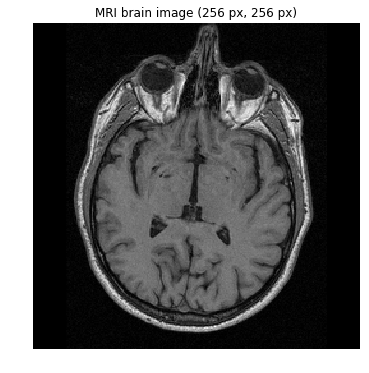

In [66]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In [67]:
# Some stuff
brain_im

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [68]:
# Region growing algorithm (with better and simpler techniques)
from skimage.util.shape import view_as_blocks
from scipy import ndimage

def neighbours_coord(x,y,shape):
    """Get the indexes of the neighbours of the current pixels without having invalid coordinates"""
    # Get the index of the maximum position 
    im_x = shape[0] -1
    im_y = shape[1] -1
    
    l_idx = []
    
    # Above
    idx_x = max(x-1,0)
    idx_y = y
    l_idx.append((idx_x,idx_y))
    # Above-right
    idx_x = max(x-1,0)
    idx_y = min(y+1,im_y)
    l_idx.append((idx_x,idx_y))
    # Right
    idx_x = x
    idx_y = min(y+1,im_y)
    l_idx.append((idx_x,idx_y))
    # Under-right
    idx_x = min(x+1,im_x)
    idx_y = min(y+1,im_y)
    l_idx.append((idx_x,idx_y))
    # Below
    idx_x = min(x+1,im_x)
    idx_y = y
    l_idx.append((idx_x,idx_y))
    # Under-left
    idx_x = min(x+1,im_x)
    idx_y = max(y-1,0)
    l_idx.append((idx_x,idx_y))
    # Left
    idx_x = x
    idx_y = max(y-1,0)
    l_idx.append((idx_x,idx_y))
    # Above-left
    idx_x = max(x-1,0)
    idx_y = max(y-1,0)
    l_idx.append((idx_x,idx_y))
    
    return l_idx
    
    

def region_predicate_1(block,thres_mean,thres_std):
    mean = block.mean()
    std  = block.std()
    if mean < thres_mean and std < thres_std:
        return True
    else:
        return False    
    
def region_predicate_2(b_array,p_x,p_y,seed_x,seed_y,thres):
    b_mean = b_array[p_x,p_y].mean()
    s_mean = b_array[seed_x,seed_y].mean()
    if abs(b_mean-s_mean) < thres:
        return True
    else:
        return False    
    
def region_growing_slow(im,seed_x,seed_y):
    """NOT EFFICIENT AND SLOW"""
    # Parameters
    im_processed = np.zeros(im.shape,dtype=bool) # Array of all the processed pixels
    print(im_processed.shape)
    
    out_im = np.zeros(im.shape) # Output image  
    im_shape = im.shape
    size_image = im_shape[0]*im_shape[1]
    threshold = 4
    # Main code
    # First pixel already processed 
    im_processed[seed_x,seed_y] = True
    out_im[seed_x,seed_y] = 255
    # Get the neighbours around the seed
    l_neighbours = neighbours_coord(seed_x,seed_y,im_shape)# List of the neighbours to process
    i = 0
    u = 0
    print('begin')
    # Process until we have been around all the image
    while np.count_nonzero(im_processed)!= size_image :
        # Check for each neighbour if it part of the region
        for elem_coord in l_neighbours:
            print(i)
            elem_x = elem_coord[0]
            elem_y = elem_coord[1]
            # Verify homogenity criterion
            if im_processed[elem_x,elem_y]:
                l_neighbours.remove(elem_coord)
            else:
                homogenity_crit(im,out_im,im_processed,elem_x,elem_y,seed_x,seed_y,threshold)
                # Add the neighbours (concat both list)
                n_neighbours  = neighbours_coord(elem_x,elem_y,im_shape)
                
                for elem in n_neighbours:
                    if im_processed[elem] == True:
                        n_neighbours.remove(elem)
                l_neighbours = l_neighbours + n_neighbours
                
            i = i+1
    print('end')
    
    return out_im

# Some region stuff
def homogenity_crit(im,out_im,im_processed,x,y,seed_x,seed_y,threshold_param):
    """ Simple criterion about the distance from a given region """
    if abs(int(im[x,y]) - int(im[seed_x,seed_y])) < threshold_param:
        out_im[x,y] = 255 # Add in the growing region
    im_processed[x,y] = True 
    

def region_growing(im,seed_x,seed_y,threshold=16):
    #region growing method. Start somewhere and recursively see if neighboring pixels satisfy homogeneity criterion
    #homogeneity threshold: intensity between twe neighbors lower than threshold
    #stard point: 128,140
    area, old_area = 1, 0
    region_g = im
    #table with 0 not visited, 1 visited and part of the region, 2 visited and part of the frontier, 3 visited and not part of the region
    visit_table = np.zeros(im.shape,dtype = int)
    visit_table[seed_x][seed_y] = 2

    mean = region_g[seed_x][seed_y]

    while old_area < area:
        old_area = area
        #look in image where we need to visit neighbors
        for k in range(1, im_h-1):#all image except last lines and columns which won't have unvisited neighbors
            for l in range(1,im_w-1):
                if visit_table[k][l] == 2: #if it is part of the frontier we look at its neighbors
                    visit_table[k][l] = 1 #set as visited
                    for i in range(k-1, k+2):#range begins at k-1 and ends at k+1
                        for j in range(l-1,l+2):
                            if visit_table[i][j] == 0: #neighbors not yet visited
                                homo = abs(int(region_g[i][j]) - mean)
                                if homo < threshold:
                                    area = area + 1
                                    visit_table[i][j] = 2
                                    mean = (mean*(area-1) + region_g[i][j])/area
                                else: 
                                    visit_table[i][j] = 3


    for k in range(0, im_h):#all image except last lines and columns which won't have unvisited neighbors
        for l in range(0,im_w):
            if visit_table[k][l] == 1 or visit_table[k][l] == 2:
                region_g[k][l] = 255
                
    return region_g


In [69]:
brain_im.shape

(256, 256)

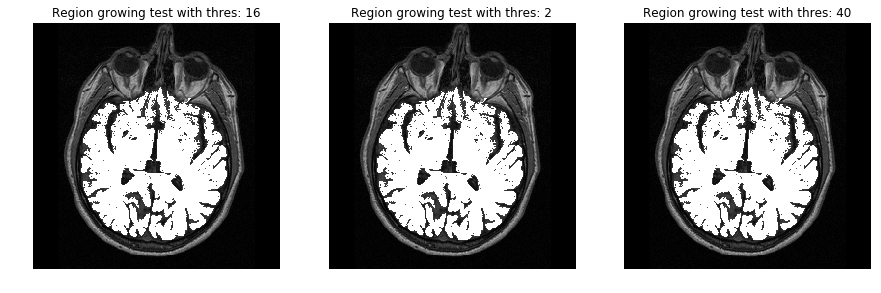

In [70]:
seed_x,seed_y = 128, 140

threshold_p = 16
out_im_1 = region_growing(brain_im,seed_x,seed_y,threshold=threshold_p)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(out_im_1, cmap='gray')
ax[0].set_title('Region growing test with thres: {}'.format(threshold_p))
ax[0].axis('off')

threshold_p = 2
out_im_2 = region_growing(brain_im,seed_x,seed_y,threshold=threshold_p)

ax[1].imshow(out_im_2, cmap='gray')
ax[1].set_title('Region growing test with thres: {}'.format(threshold_p))
ax[1].axis('off')

threshold_p = 40
out_im_3 = region_growing(brain_im,seed_x,seed_y,threshold=threshold_p)

ax[2].imshow(out_im_3, cmap='gray')
ax[2].set_title('Region growing test with thres: {}'.format(threshold_p))
ax[2].axis('off')


plt.show()


### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

### 1.5 Morphological Watersheds
Discussion blabla

In [71]:
def region_merging(im,blk_size,seed_x,seed_y):
    B = view_as_blocks(im,block_shape=(blk_size,blk_size))
    blk_x,blk_y = (seed_x//blk_size,seed_y//blk_size)
    # TODO the rest


## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [72]:
import os
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
data_path = os.path.join(data_base_path, data_folder)
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


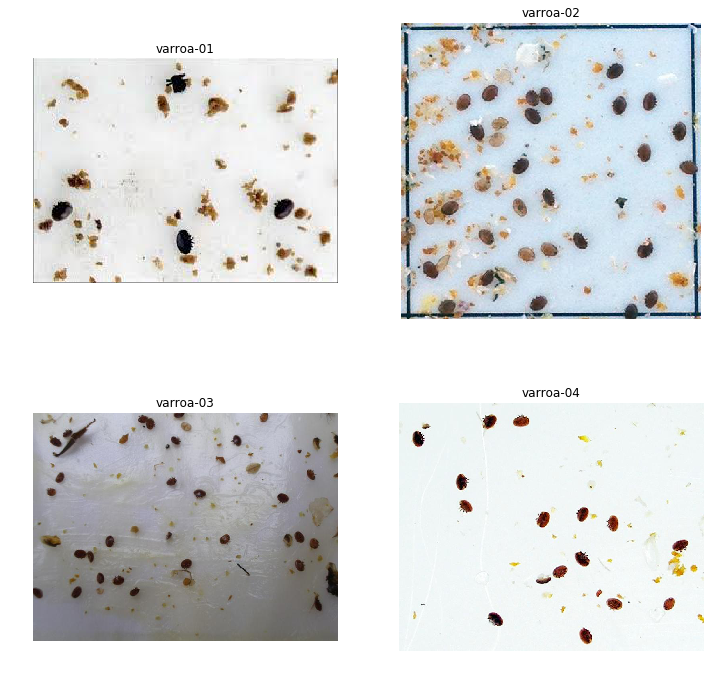

In [73]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [74]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [75]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

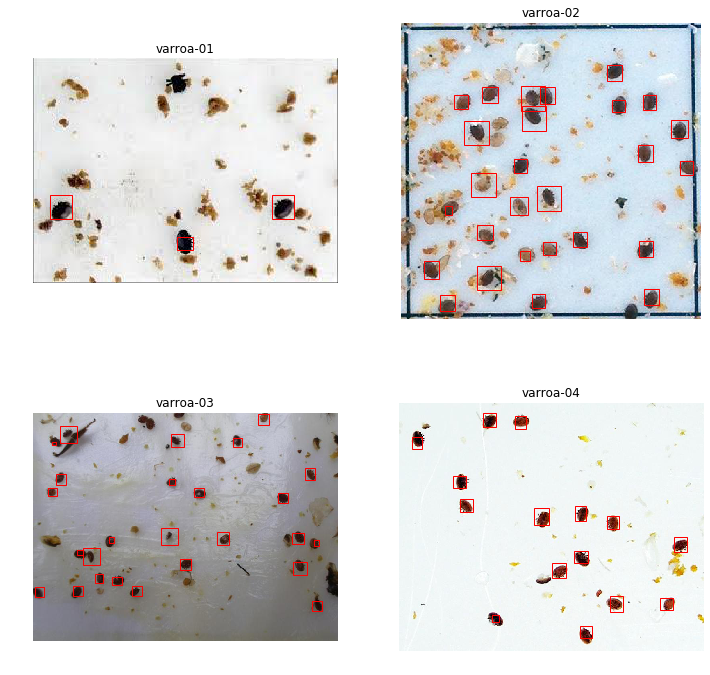

In [76]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

In [77]:
print(annotations_xmls[0])
print(annotations_xmls[0][0])
print(annotations_xmls[0][0]['bbox'])


[{'name': 'Varroa', 'bbox': [14, 117, 19, 20]}, {'name': 'Varroa', 'bbox': [204, 117, 19, 20]}, {'name': 'Varroa', 'bbox': [123, 153, 13, 11]}]
{'name': 'Varroa', 'bbox': [14, 117, 19, 20]}
[14, 117, 19, 20]


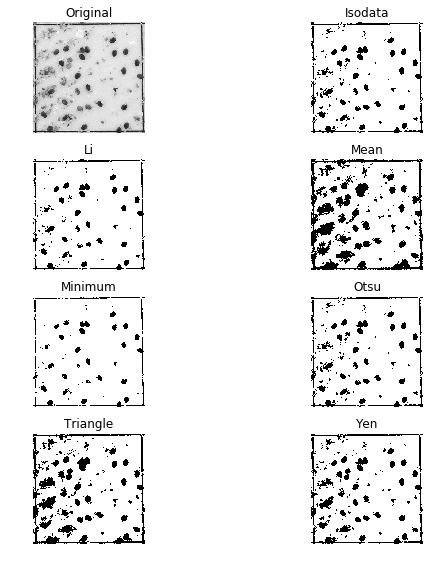

In [78]:
# ic is an image collection of the 4 images

# Try all kind of thresholding on gray_level images
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold
from skimage.color import rgb2gray

img_color = ic[1]
img_gray = rgb2gray(img_color)

fig, ax = try_all_threshold(img_gray, figsize=(10, 8), verbose=False)
plt.show()

In [79]:
# Import stuff
from skimage.filters import threshold_minimum
from skimage.color   import rgb2gray
from skimage.measure import label

from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

def pipeline(rgb_input_img):
    """ Input : RGB image of varroa infection
        Ouput : Binary image of detected varroa 
        Function : Process the image in order to keep the relevant informations """
    # Data : ic[0..3]
    color = {'red':0,'green':1,'blue':2}

    # Principal pipeline 

    # Preprocessing
    
    # Contrast enhancement
    sigmoid_p = 0.5
    #rgb_input_img = skimage.exposure.equalize_adapthist(rgb_input_img, kernel_size=None, clip_limit=0.01, nbins=256)
    rgb_input_img = skimage.exposure.adjust_sigmoid(rgb_input_img, cutoff=sigmoid_p, gain=10, inv=False)    
    
    # Color Selection
    single_canal = False
    
    if single_canal==True:
        input_img = rgb_input_img[:,:,color['red']]  # Take a single canal 
    else:
        input_img = rgb2gray(rgb_input_img)
    
    # Morphology operations
    
    struct_elem = disk(4)
    morph_img   = dilation(input_img, struct_elem)# Remove waste on images
    struct_elem = disk(4)
    morph_img   = erosion(morph_img,struct_elem) # Give proportion again to varroa
    
    # Thresholding
    
    # Minimum method thres.
    min_thres = threshold_minimum(morph_img)
        
    # Binarization
    bin_min  = morph_img < min_thres


    # Plot the results
    plot_processing = False
    if True == plot_processing:
        fig, axes = plt.subplots(ncols=3, figsize=(15, 15))
        ax = axes.ravel()

        ax[0].imshow(input_img)
        ax[0].set_xlabel('Orig.')

        ax[1].imshow(morph_img)
        ax[1].set_xlabel('Morph. processing.')

        ax[2].imshow(bin_min)
        ax[2].set_xlabel('Minimal thres.')
        plt.show()
    
    
    # Assign the output to final processing
    output = bin_min
    
    return output

def label_varroa_region(input_image):
    """ Input  : Binary image of detected varroa
        Output : Multiples labellised regions of the image"""
    output_labels,num_labels = label(input_image,return_num=True,connectivity=None)
    return output_labels

label_list = []

for img in ic:
    bin_img = pipeline(img)
    output_labels = label_varroa_region(bin_img)
    label_list.append(output_labels)



### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In [88]:
from skimage.measure import regionprops

def xml_annotation_to_bbox(xml_annotation):
    """ Convert an xml annotation to a list of bbox tuples"""
    bbox_list = []
    for elem in xml_annotation:
        bbox_coords = elem['bbox']
        bbox_tuple  = tuple(bbox_coords)
        bbox_list.append(bbox_tuple)
    
    return bbox_list


def iou_bbox(gt_reg,pred_reg):
    """ 
        Compute the IoU between two region with their bounding boxes
        
        Insipired from : https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
        
        Parameters
        ----- 
        pred_reg format : (MIN_ROW,MIN_COL,MAX_ROW,MAX_COL)
        pred_reg pixels in bounding box are in half-open interval [min_row; max_row) and [min_col; max_col).
        gt_reg h-format : (x, y, width, heigth) in some cartesian form
        gt_reg format   : (MIN_COL,MIN_ROW, MAX_ROW-MIN_ROW, MAX_COL-MIN_COL)
        
        Return
        -----
        float val in [0,1]
    """
    # x:rows and y:colummns are (0,0) at right corner
    
    # Harmonize the coordinates systems of the bounding boxes
    g_y_min,g_x_min,diff_x,diff_y   = gt_reg
    g_y_max = g_y_min + diff_y 
    g_x_max = g_x_min + diff_x
    
    # In ground truth max_values are inside the bbox but in label are outside 
    p_x_min,p_y_min,p_x_max,p_y_max = pred_reg
    # Correctoin of max values
    p_x_max = p_x_max - 1
    p_y_max = p_y_max - 1
 
    # Determine the (x,y) coordinates of the intersection rectangle
    i_x_min = max(p_x_min,g_x_min)
    i_y_min = max(p_y_min,g_y_min)
    i_x_max = min(p_x_max,g_x_max)
    i_y_max = min(p_y_max,g_y_max)
    
    # Compute the intersection area (robust to non-matching rect.s)
    inter_area = max(0,i_x_max -  i_x_min + 1) * max(0,i_y_max - i_y_min + 1)
    
    # Compute the area of both the prediction and the ground-truth
    pred_rect = (p_x_max-p_x_min+1)*(p_y_max-p_y_min+1) 
    gt_rect   = (g_x_max-g_x_min+1)*(g_y_max-g_x_min+1)
    
    # Compute the intersection over union
    iou_val = inter_area/(gt_rect+pred_rect-inter_area)
    return iou_val
    
    

def detection_statistics(pred_image,gt_labels,threshold):
    """
    
    Returns a tuple composed by pred_region_status and gt_region_status
    
    Parameters
    ------
      
    
    Returns
    ------
    (pred_region_status,gt_region_status)
    
    pred_region status :
    a list of size of number of predicted region having the following status depending on the IoU criteria
    3 : True  positive (region is correct)
    1 : False positive (region doesn't exist in ground truth or don't match enough)
    
    gt_region_status :
    a list of size of number of ground truth region having the following status depending on the IoU criteria
    0 : Region being detected
    -3: False negative (existing region not detected)
    """
      
    props_list = regionprops(pred_image) # Properties of the labelled image
    pred_region_status = np.zeros(len(props_list)) # Select between true or false positive
    pred_region_argmax = np.zeros(len(props_list)) # Array that stores the best IoU idx per predicted region
    gt_region_status = np.zeros(len(gt_labels))    # Store if ground truth region is being detected.
    
    # Rows : Gt regions,Cols : Predicted regions
    iou_array = np.zeros((len(gt_labels),len(props_list)),dtype=np.float64)     
    
    # Compute all the IoU bruteforce method
    for idx_a,a in enumerate(gt_labels):
        for idx_b,b in enumerate(props_list):
            b_bbox = b.bbox
            print("gt_idx {} / reg_idx {} ".format(idx_a,idx_b))
            print("Bbox coords ----------")
            print("GT : {}\nPRED : {}".format(a,b_bbox))
            iou_array[idx_a,idx_b] = iou_bbox(a,b_bbox)
    print("--------------")
    print("mtx size : {}",iou_array.shape)
    print(iou_array)
    print("--------------")
    
    # Compute the false positive (pred region which IoU equals 0 over the ground truth is equal to zero)
    false_pos_idx = [iou_array.sum(0) == 0]
    pred_region_status[false_pos_idx] = 1.0 # False positive
    pred_region_argmax[false_pos_idx] = -1.0 # False positive then no assignation to a region
    
    # Compute the true positive depending on the threshold
    for pred_idx,elem in enumerate(pred_region_status):
        if elem != 1.0:
            gt_idx = iou_array[:,pred_idx].argmax() # Get the maximum IoU
            # Check if IoU is above the threshold
            if iou_array[gt_idx,pred_idx] >= threshold:
                pred_region_status[pred_idx] = 3. # True positive
                pred_region_argmax[pred_idx] = gt_idx # Assign the predicted region to a ground truth region
            else:
                pred_region_status[pred_idx] = 1.   # False positive
                pred_region_argmax[pred_idx] = -1.0 # False positive then no assignation to a region       
                
    # Compute the false negative
    for idx,elem in enumerate(gt_region_status):
        if idx not in pred_region_argmax: # If no predicted region has been assigned to a ground truth region
            gt_region_status[idx] = -3.0 # False negative
    
    return (pred_region_status,gt_region_status)
    


### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

In [89]:
def precision(region_status,gt_status):
    """ Compute the precision of the image detection tp/tp+fp"""
    unique,counts = np.unique(region_status, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    tp = stats_dict.get(3.0,0.0) # Get the number of true positive
    fp = stats_dict.get(1.0,0.0) # Get the number of false positive 
    return tp/(tp+fp)

def recall(region_status,gt_status):
    """ Compute the recall of the image detection tp/tp+fn"""
    
    unique,counts = np.unique(region_status, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    print(stats_dict)
    tp = stats_dict.get(3.0,0.0) # Get the number of true positive
    
    unique,counts = np.unique(region_status, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    fn = stats_dict.get(-3.0,0.0) # Get the number of false negative 
    return tp/(tp+fn)

def f1_score(region_stats,gt_stats):
    """"""
    rec  = recall(region_stats,gt_stats)
    prec = precision(region_stats,gt_stats)
    f1_val = 2*prec*rec/(rec+prec)
    print("Stats : {} / {} / {}".format(rec,prec,f1_val))
    return f1_val

# Process the images and print some statistics
# TODO : No print at the moment 
for idx,img in enumerate(ic):
    bin_img = pipeline(img)
    label_img = label_varroa_region(bin_img)
    gt_labels = xml_annotation_to_bbox(annotations_xmls[idx])
    # Proceed to gather statistics
    print("img {}".format(idx))
    thres_list =  [0.5,0.9]
    for thres in thres_list:
        reg_stats,gt_stats = detection_statistics(label_img,gt_labels,thres)
        print(reg_stats)
        print (gt_stats)
        f1_score(reg_stats,gt_stats)
        

img 0
gt_idx 0 / reg_idx 0 
Bbox coords ----------
GT : (14, 117, 19, 20)
PRED : (15, 117, 30, 131)
gt_idx 0 / reg_idx 1 
Bbox coords ----------
GT : (14, 117, 19, 20)
PRED : (102, 31, 112, 42)
gt_idx 0 / reg_idx 2 
Bbox coords ----------
GT : (14, 117, 19, 20)
PRED : (121, 206, 138, 223)
gt_idx 0 / reg_idx 3 
Bbox coords ----------
GT : (14, 117, 19, 20)
PRED : (124, 16, 140, 34)
gt_idx 0 / reg_idx 4 
Bbox coords ----------
GT : (14, 117, 19, 20)
PRED : (148, 122, 168, 136)
gt_idx 1 / reg_idx 0 
Bbox coords ----------
GT : (204, 117, 19, 20)
PRED : (15, 117, 30, 131)
gt_idx 1 / reg_idx 1 
Bbox coords ----------
GT : (204, 117, 19, 20)
PRED : (102, 31, 112, 42)
gt_idx 1 / reg_idx 2 
Bbox coords ----------
GT : (204, 117, 19, 20)
PRED : (121, 206, 138, 223)
gt_idx 1 / reg_idx 3 
Bbox coords ----------
GT : (204, 117, 19, 20)
PRED : (124, 16, 140, 34)
gt_idx 1 / reg_idx 4 
Bbox coords ----------
GT : (204, 117, 19, 20)
PRED : (148, 122, 168, 136)
gt_idx 2 / reg_idx 0 
Bbox coords -------

C:\Users\Ismail-P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Ismail-P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


ZeroDivisionError: float division by zero